In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure
from scipy.stats import wasserstein_distance

import torch

import random
import copy
import math
import cv2
import os
import sys

2024-02-22 00:24:46.008599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 00:24:46.039377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 00:24:46.039402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 00:24:46.040220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 00:24:46.045432: I tensorflow/core/platform/cpu_feature_guar

# TRAINED MODELS
## Variables definition

In [2]:
div = 64
step = int(32/4)
red = 1

box = 4
kernel = np.ones((box,box),np.float32)/(box**2)

map_list_t = ['master_big','master_big_closed','master_big_semiclosed']
map_root_name = 'master_big'
# map_list = ['map2','stanford_hyang10','master_big','willow','costacafe','map1','map3','stanford_coupa0', 'stanford_coupa3','stanford_hyang1','stanford_gates2']
map_list = ['stanford_coupa0', 'stanford_coupa1', 'stanford_coupa2', 'stanford_coupa3', 'stanford_deathCircle0', 'stanford_gates2', 'stanford_hyang2', 'stanford_hyang3', 'stanford_hyang4', 'stanford_hyang10', 'stanford_little3', 'stanford_nexus0']#, 'stanford_nexus1']

# sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree','restricted','grass','intersection','shadow']
sem_dict = ['bicycle_road', 'building', 'entrance', 'grass', 'obstacle', 'parking', 'pedestrian_road', 'tree', 'vehicle_road']
chans = len(sem_dict)

lut_in = [0, 20, 50, 100, 150, 255]
lut_out = [0, 100, 180, 220, 240, 255]
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

# Loading of the models

In [3]:
# spec = 'stan'
# date = '01feb'

# model = tf.keras.models.load_model('IRI_models/'+date+'_'+str(step)+'px_steps_'+spec+'_paths')

# model1 = tf.keras.models.load_model('IRI_models/'+date+'_8px_steps_'+spec+'_vels')

# model2 = tf.keras.models.load_model('IRI_models/'+date+'_8px_steps_'+spec+'_stops')

## Testing closed corridors (completely or partially closed)

In [4]:
# for map_name in map_list_t:
#   print(map_name)

#   lines = 0
#   with open('maps/semantics/'+map_root_name+'/'+map_name+'.csv') as f:
#     lines = f.readlines()

#   h = len(lines)
#   w = len(lines[0].split(','))

#   # Converts data to a list of integers
#   map = []
#   for line in lines:
#     map.extend([int(c) for c in line.split(',')])

#   for lab_class in sem_dict:
#     lines = 0
#     try:
#       with open('maps/semantics/'+map_root_name+'/'+map_root_name+'_sem_'+lab_class+'.csv') as f:
#         lines = f.readlines()

#       hh = len(lines)
#       ww = len(lines[0].split(','))

#       if hh != h or ww != w:
#         print(f'h: {h}\tw: {w}')
#         print(f'h: {hh}\tw: {ww}')
#         raise SystemExit("ERROR: Different sizes!!")

#       # Converts data to a list of integers
#       for line in lines:
#         map.extend([int(c) for c in line.split(',')])

#     except FileNotFoundError:
#       for i in range(h):
#         for j in range(w):
#           map.extend([255])

#   map = np.reshape(map,[chans,h,w])
#   map = np.moveaxis(map, 0, -1)
#   map = map/255

#   map_aux = map
#   map = np.zeros((int(math.ceil(h/2)),int(math.ceil(w/2)),chans))

#   for idx in range(chans):
#     map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (2,2), np.max)
#   h, w, _ = map.shape

#   diff_h = int((h-div*int(h/div))/2)
#   r_h = int((h-div*int(h/div))%2) + diff_h
#   diff_w = int((w-div*int(w/div))/2)
#   r_w = int((w-div*int(w/div))%2) + diff_w
#   map = map[r_h:-diff_h:,r_w+diff_w:,:]

#   # print(map.shape)
#   h, w, _ = map.shape

#   # -----------------------------------------------------------------------------------
#   # creating subplot and figure
#   fig = plt.figure(figsize=(w/70,h/70))
#   data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

#   step = int(32/4)
#   for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
#     c = int(i%(w/step+int(div/step-1))) - int(div/step-1)*0
#     r = int(i/(w/step+int(div/step-1))) - int(div/step-1)*0
#     submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
#     subdata = model.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
#     subdata = np.squeeze(subdata,axis=0)
#     data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
#   contrasted_data = cv2.LUT((data_pred/np.max(data_pred)*255).astype(np.uint8), lut_8u).astype(float)/255
#   plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(contrasted_data.shape,1),1-contrasted_data,1-contrasted_data),axis=2)), vmin=0, vmax=1)
#   # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
#   plt.show()

## Model 1 testing

stanford_coupa0


2024-02-22 00:24:49.348598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 989 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-02-22 00:24:49.349123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 989 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:68:00.0, compute capability: 8.6


2024-02-22 00:24:53.036927: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


h: 78	w: 140
['bicycle_road', 'building', 'entrance', 'grass', 'obstacle', 'parking', 'pedestrian_road', 'tree', 'vehicle_road']


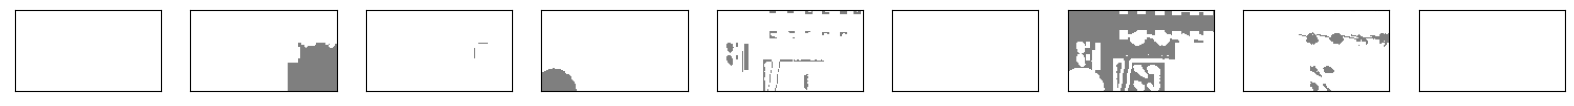

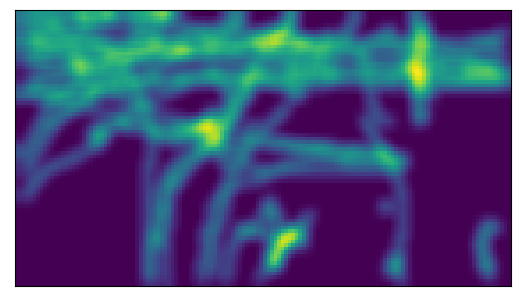

2024-02-22 00:24:53.989256: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-22 00:24:54.114014: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


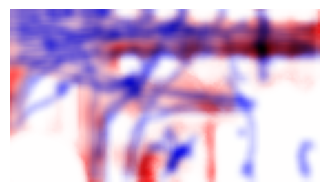

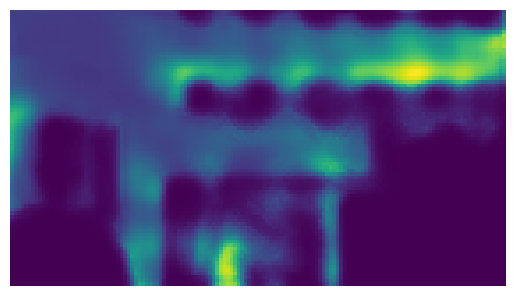

KL-divergence: 0.6545090079307556
Reverse KL-divergence: 1.8322943449020386
EMD: 13.75
MSE: 9.00e-09
-----------------------------
Mean KL-divergence: 0.6545090079307556
Std KL-divergence: 0.0
Mean reverse KL-divergence: 1.8322943449020386
Std reverse KL-divergence: 0.0
Mean EMD: 1.38e+01
Std EMD: 0.00e+00


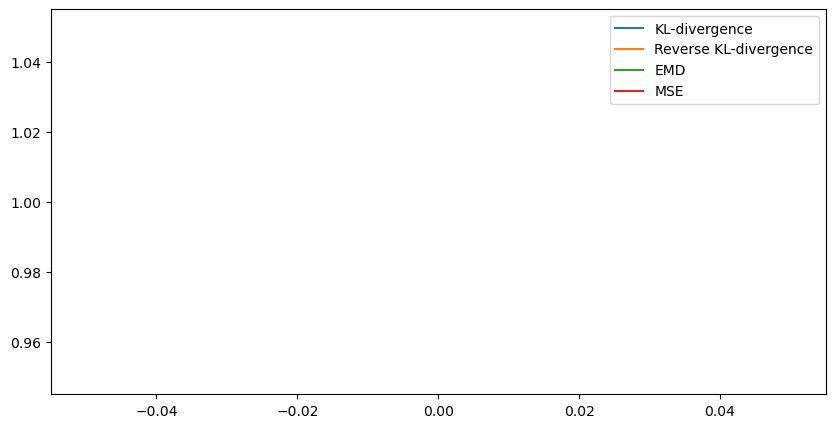

In [5]:
kl1 = []
kli1 = []
was1 = []
mse1 = []

if True:
  map_name = 'stanford_coupa0'

# for map_count, map_name in enumerate(map_list):
  print(map_name)

  model = tf.keras.models.load_model('IRI_models/final4_9labels_'+map_name)

  # Converts data to a list of integers
  map = []
  for lab_class in sem_dict:
    lines = 0
    try:
      with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'-reduced.csv') as f:
        lines = f.readlines()

      h = len(lines)
      w = len(lines[0].split(','))

      # Converts data to a list of integers
      for line in lines:
        map.extend([int(c) for c in line.split(',')])
    
    except FileNotFoundError:
      try:
        with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
          lines = f.readlines()

        h = len(lines)
        w = len(lines[0].split(','))

        # Converts data to a list of integers
        for line in lines:
          map.extend([int(c) for c in line.split(',')])

      except FileNotFoundError:
        for i in range(h):
          for j in range(w):
            map.extend([255])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/red)),int(math.ceil(w/red)),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red,red), np.max)

  # print(map.shape)
  h, w, _ = map.shape

  print(f'h: {h}\tw: {w}')

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-new.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([float(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  data = skimage.measure.block_reduce(data, (red,red), np.max)

  data_show = data
  data_show = cv2.filter2D(data_show,-1,kernel)
  data_show = cv2.filter2D(data_show,-1,kernel)
  data = data_show/np.sum(data_show)
  data_show = data_show/np.max(data_show)

  # print(data.shape)
  hd, wd = data.shape

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    ax = plt.subplot(1, len(sem_dict), i+1)
    alp = 0.5
    ax.imshow(np.stack((map[:,:,i],map[:,:,i],map[:,:,i]),axis=2)*alp+(1-alp), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  ax.imshow(data_show)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # ax = plt.subplot(111)
  # ax.imshow(data_show, vmin=0, vmax=1)
  # ax.get_xaxis().set_visible(False)
  # ax.get_yaxis().set_visible(False)
  # plt.show()

  # -----------------------------------------------------------------------------------
  # Random sample 32x32 windows in map
  n_crops = 1000
  inserted = 0
  crops = np.zeros((n_crops,2),dtype=int)
  selections = np.zeros((h,w))
  for i in range(n_crops):
    background = np.zeros((h,w))
    flag = True
    while flag:
      aux_x = int(random.random()*(w-div+1))
      aux_y = int(random.random()*(h-div+1))
      flag = False
      # print(f'INSERTED: {inserted}  ->  x: {aux_x} and y: {aux_y}')
      # for z in range(inserted):
      #   if abs(aux_x-crops[z,0])<int(div/10) and abs(aux_y-crops[z,1])<int(div/10):
      #     # print('too close')
      #     flag = True
    crops[i,0] = aux_x
    crops[i,1] = aux_y
    selections = selections+cv2.rectangle(background,(crops[i,0],crops[i,1]),(crops[i,0]+div-1,crops[i,1]+div-1),(1,0,0),-1)
    inserted = inserted + 1
  selections = 1/selections

  # -----------------------------------------------------------------------------------
  # creating subplot and figure
  # ax = plt.subplot(111)
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
  kls = []
  for i in range(n_crops):
    submap = map[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div,:]
    data_aux = data[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    subdata = model.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,0]
    subdata = np.squeeze(subdata,axis=0)
    data_pred[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
    # Calculate the KL-divergence
    
  data = torch.Tensor(data)
  data_pred = torch.Tensor(data_pred)
  data = data/data.sum()
  data_pred = data_pred/data_pred.sum()
  data_pred[data_pred == 0] = 1e-12
  data_pred[data_pred == 1] = 1-1e-12
  data[data == 0] = 1e-12
  data[data == 1] = 1-1e-12

  kl = torch.nn.functional.kl_div(data_pred.unsqueeze(0).log(), data.unsqueeze(0), reduction='batchmean').item()
  kli = torch.nn.functional.kl_div(data.unsqueeze(0).log(), data_pred.unsqueeze(0), reduction='batchmean').item()
  h, w = data.shape
  data_aux = (data / data.max() * 255).detach().cpu().numpy().astype(int)
  pred_aux = (data_pred / data_pred.max() * 255).detach().cpu().numpy().astype(int)
  hist_a = [0.0] * 256
  for i in range(h):
    for j in range(w):
      hist_a[data_aux[i, j]] += 1
  hist_b = [0.0] * 256
  for i in range(h):
    for j in range(w):
      hist_b[pred_aux[i, j]] += 1
  was = wasserstein_distance(hist_a, hist_b)
  mse = ((data - data_pred)**2).mean()

  data = data/data.max()
  data_pred = data_pred/data_pred.max()
  plt.figure(figsize=(4,4))
  plt.imshow(np.multiply(np.stack((1-data,1-data,np.full(data.shape,1)),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)))
  plt.axis('off')
  plt.show()
  
  data_pred = data_pred/np.max(data_pred.detach().cpu().numpy())
  plt.imshow(data_pred)
  # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),1-data_pred,1-data_pred),axis=2)), vmin=0, vmax=1)
  plt.axis('off')
  plt.show()

  print(f'KL-divergence: {kl}')
  print(f'Reverse KL-divergence: {kli}')
  print(f'EMD: {was:.2f}')
  print(f'MSE: {mse:.2e}')
  kl1 = np.append(kl1,kl)
  kli1 = np.append(kli1,kli)
  was1 = np.append(was1,was)
  mse1 = np.append(mse1,mse)
  # import sys
  # sys.exit(0)

print('-----------------------------')
print(f'Mean KL-divergence: {np.mean(kl1)}')
print(f'Std KL-divergence: {np.std(kl1)}')
print(f'Mean reverse KL-divergence: {np.mean(kli1)}')
print(f'Std reverse KL-divergence: {np.std(kli1)}')
print(f'Mean EMD: {np.mean(was1):.2e}')
print(f'Std EMD: {np.std(was1):.2e}')

# plot all metrics normalized
plt.figure(figsize=(10,5))
plt.plot(kl1 / np.max(kl1), label='KL-divergence')
plt.plot(kli1 / np.max(kli1), label='Reverse KL-divergence')
plt.plot(was1 / np.max(was1), label='EMD')
plt.plot(mse1 / np.max(mse1), label='MSE')
plt.legend()
plt.show()